<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/SIMULACI%C3%93_A/Optimitzaci%C3%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Energia anual per panell (kWh/any): 836.8661374654132


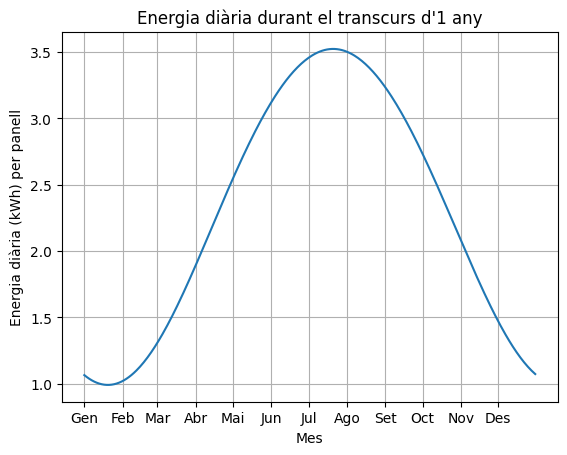

Energia anual per panell (kWh/any): 836.8661374654132
Panells òptims per cobrir l'objectiu: 4.182269831827974


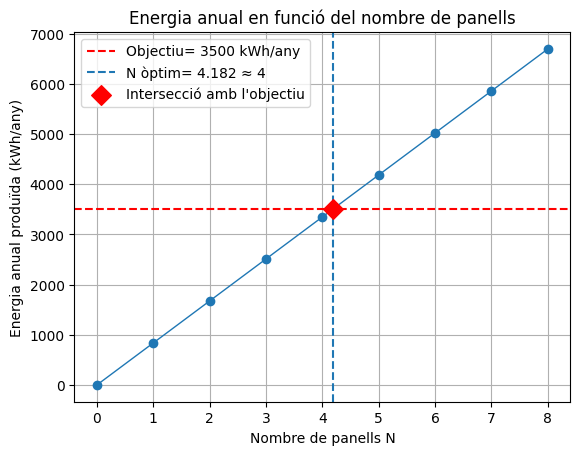

Alpha òptim (inclinació)= 40.8°
Energia anual màxima per panell= 1070.7 kWh/any


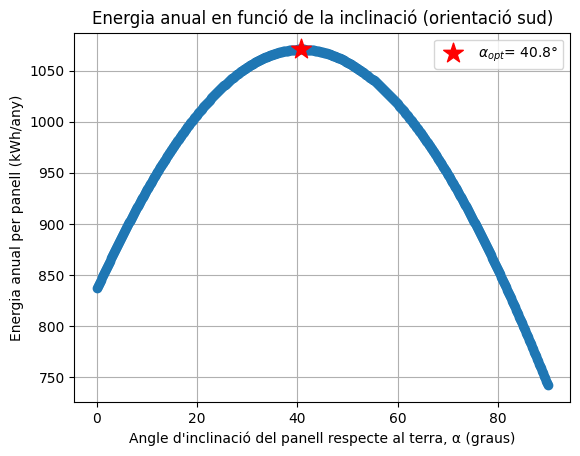

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from datetime import date, timedelta

latitud= 41.50320 * np.pi / 180   # Latitud Bellaterra en radians
area_panell= 2  # m^2
pot_max= 400    # Energia elèctrica generada per panell (W)
irr_ref= 1000   # Irradiància a la qual es genera energia_max (W/m^2)
objectiu_kWh_any= 3500 # Consum anual mitjà d'una casa (kWh/any), el farem servir com a objectiu

# Discretització temporal (un dia)
periode_dia= 24 * 3600
dt= 60 # (s)
omega= 2 * np.pi / periode_dia

# DINÀMICA PLANETÀRIA (RK4) + OBLIQÜITAT

# Dades
G= 6.67430e-11
m_sol= 1.98847e30
m_terra= 5.97219e24
m_lluna= 7.349e22
m_mart= 6.4171e23

lluna0= np.array([-1.081554325966438E+06, -1.526346829987447E+08, 5.289505218940973E+04,
 2.874182090220137E+01, 6.308874791782940E-01, 6.961580076988511E-02])

terra0= np.array([-1.393448650322997E+06, -1.528245787749783E+08, 3.246810235627741E+04,
 2.932512160332670E+01, -2.663812783881785E-01, -1.233690374052812E-03])

sol0= np.array([-6.714001826750380E+05, -8.034375730918228E+05, 2.366931954465597E+04,
 1.263663211842965E-02, -3.218117708051999E-03, -2.265135898351946E-04])

mart0= np.array([-2.458249892172696E+08, -2.180156046072930E+07, 5.595389337974356E+06,
 2.984615568179249E+00, -2.207313642037887E+01, -5.356157436277602E-01])

# --- Normalització (com la teva) ---
t0= 86400.0
m0= m_sol
r0= (G * t0**2 * m0)**(1/3)

lluna= np.concatenate((lluna0[:3]*(1/r0)*1e3, lluna0[3:]*(t0/r0)*1e3, [m_lluna/m0]))
terra= np.concatenate((terra0[:3]*(1/r0)*1e3, terra0[3:]*(t0/r0)*1e3, [m_terra/m0]))
sol  = np.concatenate((sol0[:3]*(1/r0)*1e3,   sol0[3:]*(t0/r0)*1e3,   [m_sol/m0]))
mart = np.concatenate((mart0[:3]*(1/r0)*1e3,  mart0[3:]*(t0/r0)*1e3,  [m_mart/m0]))

planetes={"luna": lluna,
          "terra": terra,
          "sol": sol,
          "mars": mart}

def unit(v):
    n= np.linalg.norm(v)
    if n < 1e-15:
        return v
    return v/n

def rodrigues(v, k, theta):
    k= unit(k)
    return (v*np.cos(theta) + np.cross(k, v)*np.sin(theta) + k*np.dot(k, v)*(1-np.cos(theta)))

def acceleracio(Num, terra, sol, lluna, mart):
  if Num=="terra":  #Terra
    dist_s = np.linalg.norm(sol[:3]-terra[:3])**3
    dist_l = np.linalg.norm(lluna[:3]-terra[:3])**3
    dist_m = np.linalg.norm(mart[:3]-terra[:3])**3

    a_x= ((sol[0]-terra[0])/dist_s + lluna[6]*(lluna[0]-terra[0])/dist_l + mart[6]*(mart[0]-terra[0])/dist_m)
    a_y= ((sol[1]-terra[1])/dist_s + lluna[6]*(lluna[1]-terra[1])/dist_l + mart[6]*(mart[1]-terra[1])/dist_m)
    a_z= ((sol[2]-terra[2])/dist_s + lluna[6]*(lluna[2]-terra[2])/dist_l + mart[6]*(mart[2]-terra[2])/dist_m)

    return np.array([a_x, a_y, a_z])

  elif Num=="sol":  #Sol
    dist_t = np.linalg.norm(terra[:3]-sol[:3])**3
    dist_l = np.linalg.norm(lluna[:3]-sol[:3])**3
    dist_m = np.linalg.norm(mart[:3]-sol[:3])**3

    a_x= (terra[6]*(terra[0]-sol[0])/dist_t + lluna[6]*(lluna[0]-sol[0])/dist_l + mart[6]*(mart[0]-sol[0])/dist_m)
    a_y= (terra[6]*(terra[1]-sol[1])/dist_t + lluna[6]*(lluna[1]-sol[1])/dist_l + mart[6]*(mart[1]-sol[1])/dist_m)
    a_z= (terra[6]*(terra[2]-sol[2])/dist_t + lluna[6]*(lluna[2]-sol[2])/dist_l + mart[6]*(mart[2]-sol[2])/dist_m)

    return np.array([a_x, a_y, a_z])

  elif Num=="luna":  #Lluna
    dist_t = np.linalg.norm(terra[:3]-lluna[:3])**3
    dist_s = np.linalg.norm(sol[:3]-lluna[:3])**3
    dist_m = np.linalg.norm(mart[:3]-lluna[:3])**3

    a_x= (terra[6]*(terra[0]-lluna[0])/dist_t + (sol[0]-lluna[0])/dist_s + mart[6]*(mart[0]-lluna[0])/dist_m)
    a_y= (terra[6]*(terra[1]-lluna[1])/dist_t + (sol[1]-lluna[1])/dist_s + mart[6]*(mart[1]-lluna[1])/dist_m)
    a_z= (terra[6]*(terra[2]-lluna[2])/dist_t + (sol[2]-lluna[2])/dist_s + mart[6]*(mart[2]-lluna[2])/dist_m)

    return np.array([a_x, a_y, a_z])

  elif Num=="mars":  #Mart
    dist_t = np.linalg.norm(mart[:3]-terra[:3])**3
    dist_l = np.linalg.norm(mart[:3]-lluna[:3])**3
    dist_s= np.linalg.norm(mart[:3]-sol[:3])**3

    a_x= (terra[6]*(terra[0]-mart[0])/dist_t + (sol[0]-mart[0])/dist_s + lluna[6]*(lluna[0]-mart[0])/dist_l)
    a_y= (terra[6]*(terra[1]-mart[1])/dist_t + (sol[1]-mart[1])/dist_s + lluna[6]*(lluna[1]-mart[1])/dist_l)
    a_z= (terra[6]*(terra[2]-mart[2])/dist_t + (sol[2]-mart[2])/dist_s + lluna[6]*(lluna[2]-mart[2])/dist_l)

    return np.array([a_x, a_y, a_z])
  else:
    return None

ordre= ["sol","terra","luna","mars"]

def acceleracions_totes(sist):
    a= np.zeros((4,3))
    for i, nom in enumerate(ordre):
        a[i]= acceleracio(nom, sist["terra"], sist["sol"], sist["luna"], sist["mars"])
    return a

def rk4_planetari_sist(sist, dt_days):
    pos0= np.array([sist[n][:3]  for n in ordre], dtype=float)
    vel0= np.array([sist[n][3:6] for n in ordre], dtype=float)

    a0= acceleracions_totes(sist)
    K1= vel0
    L1= a0

    pos2= pos0 + 0.5*dt_days*K1
    vel2= vel0 + 0.5*dt_days*L1
    sist2= copy.deepcopy(sist)
    for i, n in enumerate(ordre):
        sist2[n][:3]= pos2[i]
        sist2[n][3:6]= vel2[i]
    K2= vel2
    L2= acceleracions_totes(sist2)

    pos3= pos0 + 0.5*dt_days*K2
    vel3= vel0 + 0.5*dt_days*L2
    sist3= copy.deepcopy(sist)
    for i, n in enumerate(ordre):
        sist3[n][:3]= pos3[i]
        sist3[n][3:6]= vel3[i]
    K3= vel3
    L3= acceleracions_totes(sist3)

    pos4= pos0 + dt_days*K3
    vel4= vel0 + dt_days*L3
    sist4= copy.deepcopy(sist)
    for i, n in enumerate(ordre):
        sist4[n][:3]= pos4[i]
        sist4[n][3:6]= vel4[i]
    K4= vel4
    L4= acceleracions_totes(sist4)

    pos_new= pos0 + (dt_days/6)*(K1 + 2*K2 + 2*K3 + K4)
    vel_new= vel0 + (dt_days/6)*(L1 + 2*L2 + 2*L3 + L4)

    sist_new= copy.deepcopy(sist)
    for i, n in enumerate(ordre):
        sist_new[n][:3]= pos_new[i]
        sist_new[n][3:6]= vel_new[i]
    return sist_new

# Simulació 1 any (pas 1 hora)
dt_planetes= 1/24
passos_planetes= int(365/dt_planetes)

res_rk4= [copy.deepcopy(planetes)]
for k in range(passos_planetes):
    res_rk4.append(copy.deepcopy(rk4_planetari_sist(res_rk4[-1], dt_planetes)))

traj_rk4= np.zeros((passos_planetes+1, 4, 3))
vel_rk4 = np.zeros((passos_planetes+1, 4, 3))
for k, estat in enumerate(res_rk4):
    for i, n in enumerate(ordre):
        traj_rk4[k,i]= estat[n][:3]
        vel_rk4[k,i]= estat[n][3:6]

# Eix de rotació amb obliqüitat 23.44°
idx_sol= ordre.index("sol")
idx_terra= ordre.index("terra")

r_rel0= traj_rk4[0, idx_terra] - traj_rk4[0, idx_sol]
v_rel0= vel_rk4[0, idx_terra]  - vel_rk4[0, idx_sol]
k_orb= unit(np.cross(r_rel0, v_rel0))                      # normal al pla orbital
s0= unit(traj_rk4[0, idx_sol] - traj_rk4[0, idx_terra])    # Sol vist des de Terra
u= unit(np.cross(k_orb, s0))                               # eix al pla orbital

eps= 23.44*np.pi/180
k_spin_plus= unit(rodrigues(k_orb, u, +eps))
k_spin_minus= unit(rodrigues(k_orb, u, -eps))
eix_rotacio= k_spin_plus if np.dot(s0, k_spin_plus) > np.dot(s0, k_spin_minus) else k_spin_minus

def sol_unit_del_dia(dia_any):
    # agafem el "migdia" del dia: offset 12 hores
    steps_per_day= int(round(1.0/dt_planetes))   # 24
    mid_offset= steps_per_day//2                 # 12
    idx= (dia_any-1)*steps_per_day + mid_offset
    idx= min(idx, traj_rk4.shape[0]-1)

    rS= traj_rk4[idx, idx_sol]
    rE= traj_rk4[idx, idx_terra]
    return unit(rS - rE)

# AQUÍ ACABA LA PART DE DINÀMICA PLANETÀRIA

def derivada_vector(t, v):
    return omega * np.cross(eix_rotacio, v)

def pas_rk4(derivada, t, v, dt):
    k1= derivada(t, v)
    k2= derivada(t + 0.5*dt, v + 0.5*dt*k1)
    k3= derivada(t + 0.5*dt, v + 0.5*dt*k2)
    k4= derivada(t + dt,     v + dt*k3)
    return v + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Normal local inicial (tria meridià y=0)
# (ara ho fem coherent amb eix_rotacio: construïm una base perpendicular)
ref= np.array([0.0, 0.0, 1.0])
if np.linalg.norm(np.cross(ref, eix_rotacio)) < 1e-10:
    ref= np.array([0.0, 1.0, 0.0])

e1= unit(np.cross(ref, eix_rotacio))        # e1 ⟂ eix_rotacio
normal_inicial= unit(np.cos(latitud)*e1 + np.sin(latitud)*eix_rotacio)

# Precalcula n(t) per un dia
temps_dia= np.zeros(int(periode_dia/dt) + 1)
normal_dia= np.zeros((int(periode_dia/dt) + 1, 3))

t= 0.0
v= normal_inicial.copy()

for i in range(int(periode_dia/dt) + 1):
    normal_dia[i]= v / np.linalg.norm(v)
    temps_dia[i]= t
    if i < int(periode_dia/dt):
        v= pas_rk4(derivada_vector, t, v, dt)
        v= v / np.linalg.norm(v)   # renormalitza
        t += dt

def energia_anual_per_panell_kWh():
    energia_any_J= 0.0
    energia_diaria_kWh= np.zeros(365)

    for dia_any in range(1, 366):
        sol_unit= sol_unit_del_dia(dia_any)

        # cos(alpha)= n·s (panell horitzontal => normal= n)
        cos_alpha= np.dot(normal_dia, sol_unit)
        cos_alpha= np.maximum(0.0, cos_alpha)   # de nit o darrere el cosinus donaria negatiu així que amb aquesta linia passem a que doni 0

        irr_perp= irr_ref * cos_alpha           # W/m^2
        pot= pot_max * (irr_perp / irr_ref)     # escala lineal
        pot= np.minimum(pot, pot_max)           # saturació a 400 W

        energia_dia_J= np.sum(pot) * dt
        energia_any_J += energia_dia_J
        energia_diaria_kWh[dia_any - 1]= energia_dia_J / 3.6e6

    return energia_any_J / 3.6e6, energia_diaria_kWh

energia_panell_any_kWh, energia_diaria_kWh= energia_anual_per_panell_kWh()

print("Energia anual per panell (kWh/any):", energia_panell_any_kWh)

# Rotació per veure correctament Gen→Des
data_inici_simulacio= date(2025, 7, 21)
dates= [data_inici_simulacio + timedelta(days=i) for i in range(365)]
idx_jan1= None
for i, d in enumerate(dates):
    if d.month == 1 and d.day == 1:
        idx_jan1= i
        break

if idx_jan1 is not None:
    energia_diaria_kWh_plot= np.roll(energia_diaria_kWh, -idx_jan1)
else:
    energia_diaria_kWh_plot= energia_diaria_kWh


# Gràfic energia diària al llarg de l'any
plt.figure()
dies_any= np.arange(1, 366)
plt.plot(dies_any, energia_diaria_kWh_plot)

inicis_mes= np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
noms_mes= ["Gen", "Feb", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Oct", "Nov", "Des"]
plt.xticks(inicis_mes, noms_mes)

plt.xlabel("Mes")
plt.ylabel("Energia diària (kWh) per panell")
plt.title("Energia diària durant el transcurs d'1 any")
plt.grid(True)
plt.show()


# Nombre òptim de panells
N_optim= objectiu_kWh_any / energia_panell_any_kWh
N_optim_enter= int(N_optim)

print("Energia anual per panell (kWh/any):", energia_panell_any_kWh)
print("Panells òptims per cobrir l'objectiu:", N_optim)

# Energia anual en funció del nombre de panells
max_panells_plot= int(max(6, 2 * N_optim))
n_panells= np.arange(0, max_panells_plot + 1)

energia_total_kWh= n_panells * energia_panell_any_kWh

plt.figure()
plt.plot(n_panells, energia_total_kWh, marker='o', linewidth=1)
plt.axhline(objectiu_kWh_any, linestyle='--', color="red", label=f"Objectiu= {objectiu_kWh_any:.0f} kWh/any")
plt.axvline(N_optim, linestyle='--', label=f"N òptim= {N_optim:.3f} ≈ {N_optim_enter}")
plt.scatter([N_optim], [N_optim * energia_panell_any_kWh], marker='D', color='red', s=100, label="Intersecció amb l'objectiu", zorder=5)
plt.xlabel("Nombre de panells N")
plt.ylabel("Energia anual produïda (kWh/any)")
plt.title("Energia anual en funció del nombre de panells")
plt.grid(True)
plt.legend()
plt.show()

energia_total_kWh= n_panells * energia_panell_any_kWh

# Energia ANUAL EN FUNCIÓ DE LA INCLINACIÓ DEL PANELL (alpha)
# alpha= 0° horitzontal, alpha= 90° vertical
# Triem panell orientat cap al SUD (azimut sud) per maximitzar

z_tilde= eix_rotacio.copy()

def sud_local_unitari(n_unit):
    # Projecta -z_tilde sobre el pla perpendicular a n_unit (pla horitzontal local)
    u= -z_tilde - np.dot(-z_tilde, n_unit) * n_unit
    norma= np.linalg.norm(u)
    if norma < 1e-12:
        # Cas límit (pol): qualsevol direcció horitzontal serveix
        return np.array([0.0, 1.0, 0.0])
    return u / norma

# Precalcula sud(t) per a tot el dia
sud_dia= np.zeros_like(normal_dia)
for i in range(normal_dia.shape[0]):
    sud_dia[i]= sud_local_unitari(normal_dia[i])

def energia_anual_per_panell_inclinacio(alpha_rad):
    energia_any_J= 0.0
    n_panell_dia= (np.cos(alpha_rad) * normal_dia) + (np.sin(alpha_rad) * sud_dia)
    # Normalitzem
    normes= np.linalg.norm(n_panell_dia, axis=1)
    n_panell_dia= n_panell_dia / normes[:, None]

    for dia_any in range(1, 366):
        sol_unit= sol_unit_del_dia(dia_any)

        cos_inc= np.dot(n_panell_dia, sol_unit)
        cos_inc= np.maximum(0.0, cos_inc)

        irr_perp= irr_ref * cos_inc
        pot= pot_max * (irr_perp / irr_ref)
        pot= np.minimum(pot, pot_max)

        energia_dia_J= np.sum(pot) * dt
        energia_any_J += energia_dia_J

    return energia_any_J / 3.6e6  # kWh/any

# Possibles angles d'inclinació respecte al terra (alpha) amb orientació sud
pas_alpha= 0.2
alphas_graus= np.arange(0.0, 90.0 + pas_alpha, pas_alpha)
alphas_rad= alphas_graus * np.pi / 180

energia_any_alpha= np.array([energia_anual_per_panell_inclinacio(a) for a in alphas_rad])

# Alpha òptim (màxim)
idx_max= np.argmax(energia_any_alpha)
alpha_optim_graus= alphas_graus[idx_max]
energia_max_kWh_any= energia_any_alpha[idx_max]

print(f"Alpha òptim (inclinació)= {alpha_optim_graus:.1f}°")
print(f"Energia anual màxima per panell= {energia_max_kWh_any:.1f} kWh/any")

# Gràfica
plt.figure()
plt.plot(alphas_graus, energia_any_alpha, marker='o', linewidth=1)
plt.scatter([alpha_optim_graus], [energia_max_kWh_any], marker='*', color='red', s=220, label=fr"$\alpha_{{opt}}$= {alpha_optim_graus:.1f}°", zorder=5)
plt.xlabel("Angle d'inclinació del panell respecte al terra, α (graus)")
plt.ylabel("Energia anual per panell (kWh/any)")
plt.title("Energia anual en funció de la inclinació (orientació sud)")
plt.grid(True)
plt.legend()
plt.show()


Energia anual per panell (kWh/any): 830.7149563142849


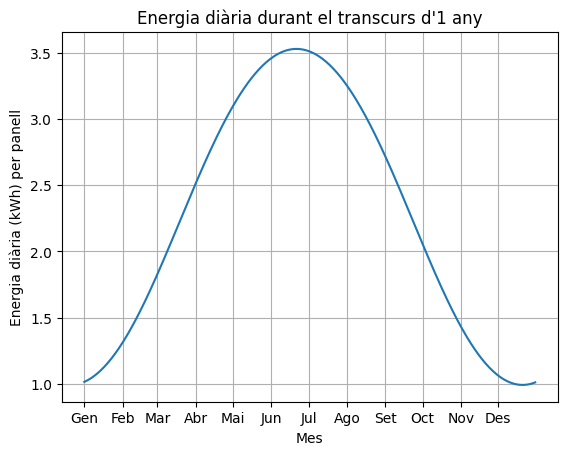

Energia anual per panell (kWh/any): 830.7149563142849
Panells òptims per cobrir l'objectiu: 4.213238215342596


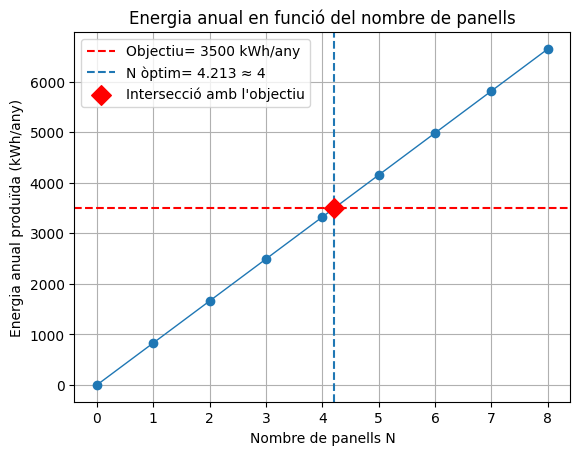

Alpha òptim (inclinació)= 41.6°
Energia anual màxima per panell= 1071.5 kWh/any


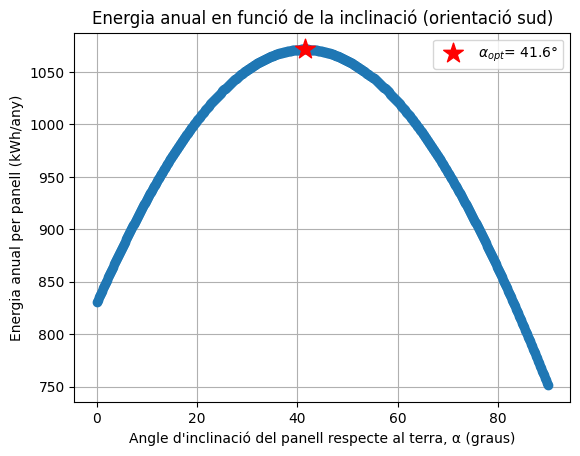

In [2]:
import numpy as np
import matplotlib.pyplot as plt

latitud= 41.50320 * np.pi / 180   # Latitud Bellaterra en radians
area_panell= 2  # m^2
pot_max= 400    # Energia elèctrica generada per panell (W)
irr_ref= 1000   # Irradiància a la qual es genera energia_max (W/m^2)
objectiu_kWh_any= 3500 # Consum anual mitjà d'una casa (kWh/any), el farem servir com a objectiu

# Discretització temporal (un dia)
periode_dia= 24 * 3600
dt= 60 # (s)
omega= 2 * np.pi / periode_dia

# RK4 AIXÒ SERÀ SUBSTITUIT PEL QUE TROBEM DE DINÀMICA PLANETÀRIA %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
eix_rotacio= np.array([0.0, 0.0, 1.0])

def derivada_vector(t, v):
    return omega * np.cross(eix_rotacio, v)

def pas_rk4(derivada, t, v, dt):
    k1= derivada(t, v)
    k2= derivada(t + 0.5*dt, v + 0.5*dt*k1)
    k3= derivada(t + 0.5*dt, v + 0.5*dt*k2)
    k4= derivada(t + dt,     v + dt*k3)
    return v + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Normal local inicial (tria meridià y=0)
# Vector radial a latitud: [cos(latitud), 0, sin(latitud)]
normal_inicial= np.array([np.cos(latitud), 0.0, np.sin(latitud)])

# Precalcula n(t) per un dia
temps_dia= np.zeros(int(periode_dia/dt) + 1)
normal_dia= np.zeros((int(periode_dia/dt) + 1, 3))

t= 0.0
v= normal_inicial.copy()

for i in range(int(periode_dia/dt) + 1):
    normal_dia[i]= v / np.linalg.norm(v)
    temps_dia[i]= t
    if i < int(periode_dia/dt):
        v= pas_rk4(derivada_vector, t, v, dt)
        v= v / np.linalg.norm(v)   # renormalitza
        t += dt


# Model solar anual: declinació delta(dia) i direcció del Sol s(delta)
# s es fixa durant el dia i només canvia amb el dia de l'any
def declinacio_solar(dia_any):
    # dia_any= 1..365 (aprox clàssica)
    return 23.44 * np.pi / 180* np.sin(2*np.pi*(dia_any - 81)/365.0)

def direccio_sol_unitaria(delta):
    # Direcció del Sol en el sistema inertial:
    # al migdia solar estaria al pla x-z; fem servir s= [cosδ, 0, sinδ]
    s= np.array([np.cos(delta), 0.0, np.sin(delta)])
    return s / np.linalg.norm(s)

# AQUÍ ACABA LA PART DE DINÀMICA PLANETÀRIA %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


def energia_anual_per_panell_kWh():
    energia_any_J= 0.0
    energia_diaria_kWh= np.zeros(365)

    for dia_any in range(1, 366):
        delta= declinacio_solar(dia_any)
        sol_unit= direccio_sol_unitaria(delta)

        # cos(alpha)= n·s (panell horitzontal => normal= n)
        cos_alpha= np.dot(normal_dia, sol_unit)
        cos_alpha= np.maximum(0.0, cos_alpha)   # de nit o darrere el cosinus donaria negatiu així que amb aquesta linia passem a que doni 0

        irr_perp= irr_ref * cos_alpha           # W/m^2
        pot= pot_max * (irr_perp / irr_ref)     # escala lineal
        pot= np.minimum(pot, pot_max)           # saturació a 400 W

        energia_dia_J= np.sum(pot) * dt
        energia_any_J += energia_dia_J
        energia_diaria_kWh[dia_any - 1]= energia_dia_J / 3.6e6

    return energia_any_J / 3.6e6, energia_diaria_kWh

energia_panell_any_kWh, energia_diaria_kWh= energia_anual_per_panell_kWh()

print("Energia anual per panell (kWh/any):", energia_panell_any_kWh)

# Gràfic energia diària al llarg de l'any
plt.figure()
dies_any= np.arange(1, 366)
plt.plot(dies_any, energia_diaria_kWh)

inicis_mes= np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
noms_mes= ["Gen", "Feb", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Oct", "Nov", "Des"]
plt.xticks(inicis_mes, noms_mes)

plt.xlabel("Mes")
plt.ylabel("Energia diària (kWh) per panell")
plt.title("Energia diària durant el transcurs d'1 any")
plt.grid(True)
plt.show()


# Nombre òptim de panells
N_optim= objectiu_kWh_any / energia_panell_any_kWh
N_optim_enter= int(N_optim)

print("Energia anual per panell (kWh/any):", energia_panell_any_kWh)
print("Panells òptims per cobrir l'objectiu:", N_optim)

# Energia anual en funció del nombre de panells
max_panells_plot= int(max(6, 2 * N_optim))
n_panells= np.arange(0, max_panells_plot + 1)

energia_total_kWh= n_panells * energia_panell_any_kWh

plt.figure()
plt.plot(n_panells, energia_total_kWh, marker='o', linewidth=1)
plt.axhline(objectiu_kWh_any, linestyle='--', color="red", label=f"Objectiu= {objectiu_kWh_any:.0f} kWh/any")
plt.axvline(N_optim, linestyle='--', label=f"N òptim= {N_optim:.3f} ≈ {N_optim_enter}")
plt.scatter([N_optim], [N_optim * energia_panell_any_kWh], marker='D', color='red', s=100, label="Intersecció amb l'objectiu", zorder=5)
plt.xlabel("Nombre de panells N")
plt.ylabel("Energia anual produïda (kWh/any)")
plt.title("Energia anual en funció del nombre de panells")
plt.grid(True)
plt.legend()
plt.show()





energia_total_kWh= n_panells * energia_panell_any_kWh

# Energia ANUAL EN FUNCIÓ DE LA INCLINACIÓ DEL PANELL (alpha)
# alpha= 0° horitzontal, alpha= 90° vertical
# Triem panell orientat cap al SUD (azimut sud) per maximitzar

z_tilde= np.array([0.0, 0.0, 1.0])

def sud_local_unitari(n_unit):
    # Projecta -z_tilde sobre el pla perpendicular a n_unit (pla horitzontal local)
    u= -z_tilde - np.dot(-z_tilde, n_unit) * n_unit
    norma= np.linalg.norm(u)
    if norma < 1e-12:
        # Cas límit (pol): qualsevol direcció horitzontal serveix
        return np.array([0.0, 1.0, 0.0])
    return u / norma

# Precalcula sud(t) per a tot el dia
sud_dia= np.zeros_like(normal_dia)
for i in range(normal_dia.shape[0]):
    sud_dia[i]= sud_local_unitari(normal_dia[i])

def energia_anual_per_panell_inclinacio(alpha_rad):
    energia_any_J= 0.0
    n_panell_dia= (np.cos(alpha_rad) * normal_dia) + (np.sin(alpha_rad) * sud_dia)
    # Normalitzem
    normes= np.linalg.norm(n_panell_dia, axis=1)
    n_panell_dia= n_panell_dia / normes[:, None]

    for dia_any in range(1, 366):
        delta= declinacio_solar(dia_any)
        sol_unit= direccio_sol_unitaria(delta)

        cos_inc= np.dot(n_panell_dia, sol_unit)
        cos_inc= np.maximum(0.0, cos_inc)

        irr_perp= irr_ref * cos_inc
        pot= pot_max * (irr_perp / irr_ref)
        pot= np.minimum(pot, pot_max)

        energia_dia_J= np.sum(pot) * dt
        energia_any_J += energia_dia_J

    return energia_any_J / 3.6e6  # kWh/any

# Possibles angles d'inclinació respecte al terra (alpha) amb orientació sud
pas_alpha= 0.2
alphas_graus= np.arange(0.0, 90.0 + pas_alpha, pas_alpha)
alphas_rad= alphas_graus * np.pi / 180

energia_any_alpha= np.array([energia_anual_per_panell_inclinacio(a) for a in alphas_rad])

# Alpha òptim (màxim)
idx_max= np.argmax(energia_any_alpha)
alpha_optim_graus= alphas_graus[idx_max]
energia_max_kWh_any= energia_any_alpha[idx_max]

print(f"Alpha òptim (inclinació)= {alpha_optim_graus:.1f}°")
print(f"Energia anual màxima per panell= {energia_max_kWh_any:.1f} kWh/any")

# Gràfica
plt.figure()
plt.plot(alphas_graus, energia_any_alpha, marker='o', linewidth=1)
plt.scatter([alpha_optim_graus], [energia_max_kWh_any], marker='*', color='red', s=220, label=fr"$\alpha_{{opt}}$= {alpha_optim_graus:.1f}°", zorder=5)
plt.xlabel("Angle d'inclinació del panell respecte al terra, α (graus)")
plt.ylabel("Energia anual per panell (kWh/any)")
plt.title("Energia anual en funció de la inclinació (orientació sud)")
plt.grid(True)
plt.legend()
plt.show()